In [36]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io as scio
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

### 数据准备

In [37]:
data = scio.loadmat("data.mat")
dt = data['dt'].item()
X = data['x']
time, dim = X.shape
print("(time, variable_dim, dt):", time, dim, dt)
t = np.arange(0, time * dt, dt)


def gradient(X, dt):  # 对序列数据求导
    dX = np.ones_like(X)
    dX[0] = (X[1] - X[0]) / dt
    dX[1:-1] = (X[2:] - X[:-2]) / (2 * dt)
    dX[-1] = (X[-1] - X[-2]) / dt
    return dX


dX = gradient(X, dt)
degree = 3

(time, variable_dim, dt): 3001 6 0.005


### 对现有数据进行代数库生成

In [38]:
library = PolynomialFeatures(degree=degree, include_bias=True)  # 只用了多项式形式的特征(多项式已经足够完成任务)
Theta = library.fit_transform(X)
print("(time, feature_dim):", Theta.shape) 
feature_num = Theta.shape[-1]
print("(ksi shape):", (feature_num, dim))
feature_name = library.get_feature_names_out()
print("feature:")
for i, f in enumerate(feature_name):
    print("({}:{})".format(i,f), end=' ')

(time, feature_dim): (3001, 84)
(ksi shape): (84, 6)
feature:
(0:1) (1:x0) (2:x1) (3:x2) (4:x3) (5:x4) (6:x5) (7:x0^2) (8:x0 x1) (9:x0 x2) (10:x0 x3) (11:x0 x4) (12:x0 x5) (13:x1^2) (14:x1 x2) (15:x1 x3) (16:x1 x4) (17:x1 x5) (18:x2^2) (19:x2 x3) (20:x2 x4) (21:x2 x5) (22:x3^2) (23:x3 x4) (24:x3 x5) (25:x4^2) (26:x4 x5) (27:x5^2) (28:x0^3) (29:x0^2 x1) (30:x0^2 x2) (31:x0^2 x3) (32:x0^2 x4) (33:x0^2 x5) (34:x0 x1^2) (35:x0 x1 x2) (36:x0 x1 x3) (37:x0 x1 x4) (38:x0 x1 x5) (39:x0 x2^2) (40:x0 x2 x3) (41:x0 x2 x4) (42:x0 x2 x5) (43:x0 x3^2) (44:x0 x3 x4) (45:x0 x3 x5) (46:x0 x4^2) (47:x0 x4 x5) (48:x0 x5^2) (49:x1^3) (50:x1^2 x2) (51:x1^2 x3) (52:x1^2 x4) (53:x1^2 x5) (54:x1 x2^2) (55:x1 x2 x3) (56:x1 x2 x4) (57:x1 x2 x5) (58:x1 x3^2) (59:x1 x3 x4) (60:x1 x3 x5) (61:x1 x4^2) (62:x1 x4 x5) (63:x1 x5^2) (64:x2^3) (65:x2^2 x3) (66:x2^2 x4) (67:x2^2 x5) (68:x2 x3^2) (69:x2 x3 x4) (70:x2 x3 x5) (71:x2 x4^2) (72:x2 x4 x5) (73:x2 x5^2) (74:x3^3) (75:x3^2 x4) (76:x3^2 x5) (77:x3 x4^2) (78:x3 x4 x

##### 按照邻接关系对代数库进行mask操作
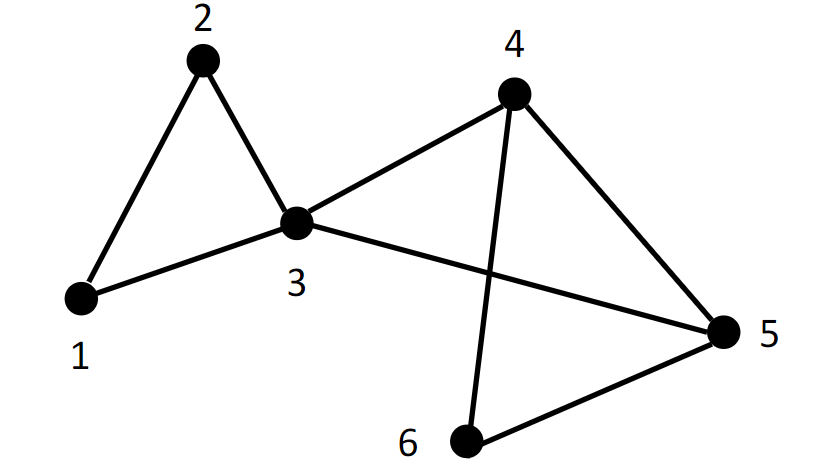

In [39]:
def findVariable(string):
    if string == '1': # 常数项
        return None
    for i in range(0, degree + 1):
        string = string.replace('^{}'.format(i), '')
    string = string.replace(' ', '')
    string = string.replace('x', '')
    numlist = list(string)
    for i in range(len(numlist)):
        numlist[i] = int(numlist[i])
    return numlist


def GetAdjTable(dim):
    Adj_Table = [0] * dim
    Adj_Table[0] = [0, 1, 2]
    Adj_Table[1] = [0, 1, 2]
    Adj_Table[2] = [0, 1, 2, 3, 4]
    Adj_Table[3] = [2, 3, 4, 5]
    Adj_Table[4] = [2, 3, 4, 5]
    Adj_Table[5] = [3, 4, 5]
    return Adj_Table


def GetMask(dim, feature_num):
    Adj_Table = GetAdjTable(dim)
    mask = np.zeros((feature_num, dim))
    for i in range(dim):
        for j in range(feature_num):
            if j == 0:  # 常数项
                mask[j, i] = 1
            else:  # 非常数项
                var = findVariable(feature_name[j])
                if len(var) == 1 and var[0] in Adj_Table[i]:
                    mask[j, i] = 1
                elif len(var) == 2 and var[0] in Adj_Table[i] and var[1] in Adj_Table[i]:
                    mask[j, i] = 1
                elif len(var) == 3 and var[0] in Adj_Table[i] and var[1] in Adj_Table[i] and var[2] in Adj_Table[i]:
                    mask[j, i] = 1
    return mask == 1


mask = GetMask(dim, feature_num)

### 阈值稀疏化脊回归

In [40]:
last_loss = .0
min_loss = 0.1
if_break = False
ksi_log = []
loss_log = pd.DataFrame(columns=["Loss"])
zoom = 5e-2  # 一个用来对随机阈值进行缩放的参数
rounds = 50
max_iter = 10
for r in range(rounds):  # 重复试验,选出最好的一组参数以及系数矩阵
    threshold = np.abs(np.random.randn(feature_num, dim))  # 生成高斯分布的阈值
    last_loss = 10.0
    loss = -0.1
    ksi = Ridge(alpha=1).fit(Theta, dX).coef_.T  # 得到一组初始解
    for k in range(max_iter):
        big_ind = np.abs(ksi) > threshold * np.exp(-1 / (100 * k + 1)) * zoom  # 随着sindy迭代的论数增加,阈值逐渐收紧
        big_ind *= mask
        ksi[~big_ind] = 0
        for i in range(6):  # 系数矩阵中的每列对应一个变量,对每个变量进行一次SINDy算法
            big_ind_perdim = big_ind[:, i]
            if big_ind_perdim.sum() == 0:  # 如果该列系数均被隐去,则跳出循环,舍弃错误的结果(这种情况很少出现)
                if_break = True
                break
            ridge = Ridge(alpha=1).fit(Theta[:, big_ind_perdim], dX[:, i])  # 调用sklearn的脊回归
            ksi[big_ind_perdim, i] = ridge.coef_
            ksi[0, i] += ridge.intercept_  # 学到的偏置需加进常数代数库的系数中
        if if_break:
            if_break = False
            break
        x0 = X[0, :]  # 序列初始值
        loss = np.linalg.norm((Theta @ ksi - dX))**2 / time  # 拟合序列导数的误差
        print("试验轮次:{}/{}, 训练轮次:{}, 序列预测损失:{}".format(r, rounds, k, loss))
        if abs(loss - last_loss) < 1e-10:
            break
        last_loss = loss

    loss_log.loc[len(loss_log)] = loss  # 若loss=-0.1则表明有ksi上有列被全部置零(极少数情况)
    if loss < min_loss:
        print("试验轮次:{}, 序列预测损失:{}".format(r, loss))
        min_loss = loss
        ksi_log.append(ksi)

试验轮次:0/50, 训练轮次:0, 序列预测损失:0.0005164830366509076
试验轮次:0/50, 训练轮次:1, 序列预测损失:0.000527342577625557
试验轮次:0/50, 训练轮次:2, 序列预测损失:0.0005257892495154195
试验轮次:0/50, 训练轮次:3, 序列预测损失:0.0005257892495154195
试验轮次:0, 序列预测损失:0.0005257892495154195
试验轮次:1/50, 训练轮次:0, 序列预测损失:0.0007589798278928319
试验轮次:1/50, 训练轮次:1, 序列预测损失:0.000765421561380544
试验轮次:1/50, 训练轮次:2, 序列预测损失:0.0007674796144259706
试验轮次:1/50, 训练轮次:3, 序列预测损失:0.0007674796144259706
试验轮次:2/50, 训练轮次:0, 序列预测损失:0.0004904038518363256
试验轮次:2/50, 训练轮次:1, 序列预测损失:0.0004938942950117111
试验轮次:2/50, 训练轮次:2, 序列预测损失:0.000494320334333567
试验轮次:2/50, 训练轮次:3, 序列预测损失:0.000494320334333567
试验轮次:2, 序列预测损失:0.000494320334333567
试验轮次:3/50, 训练轮次:0, 序列预测损失:0.0004973788239769028
试验轮次:3/50, 训练轮次:1, 序列预测损失:0.0005354674945336022
试验轮次:3/50, 训练轮次:2, 序列预测损失:0.0005351180047338481
试验轮次:3/50, 训练轮次:3, 序列预测损失:0.0005351180047338481
试验轮次:4/50, 训练轮次:0, 序列预测损失:0.0005002756888823286
试验轮次:4/50, 训练轮次:1, 序列预测损失:0.0005490292892541177
试验轮次:4/50, 训练轮次:2, 序列预测损失:0.0005487430878049469
试验轮次:4/50, 训练轮次:3, 

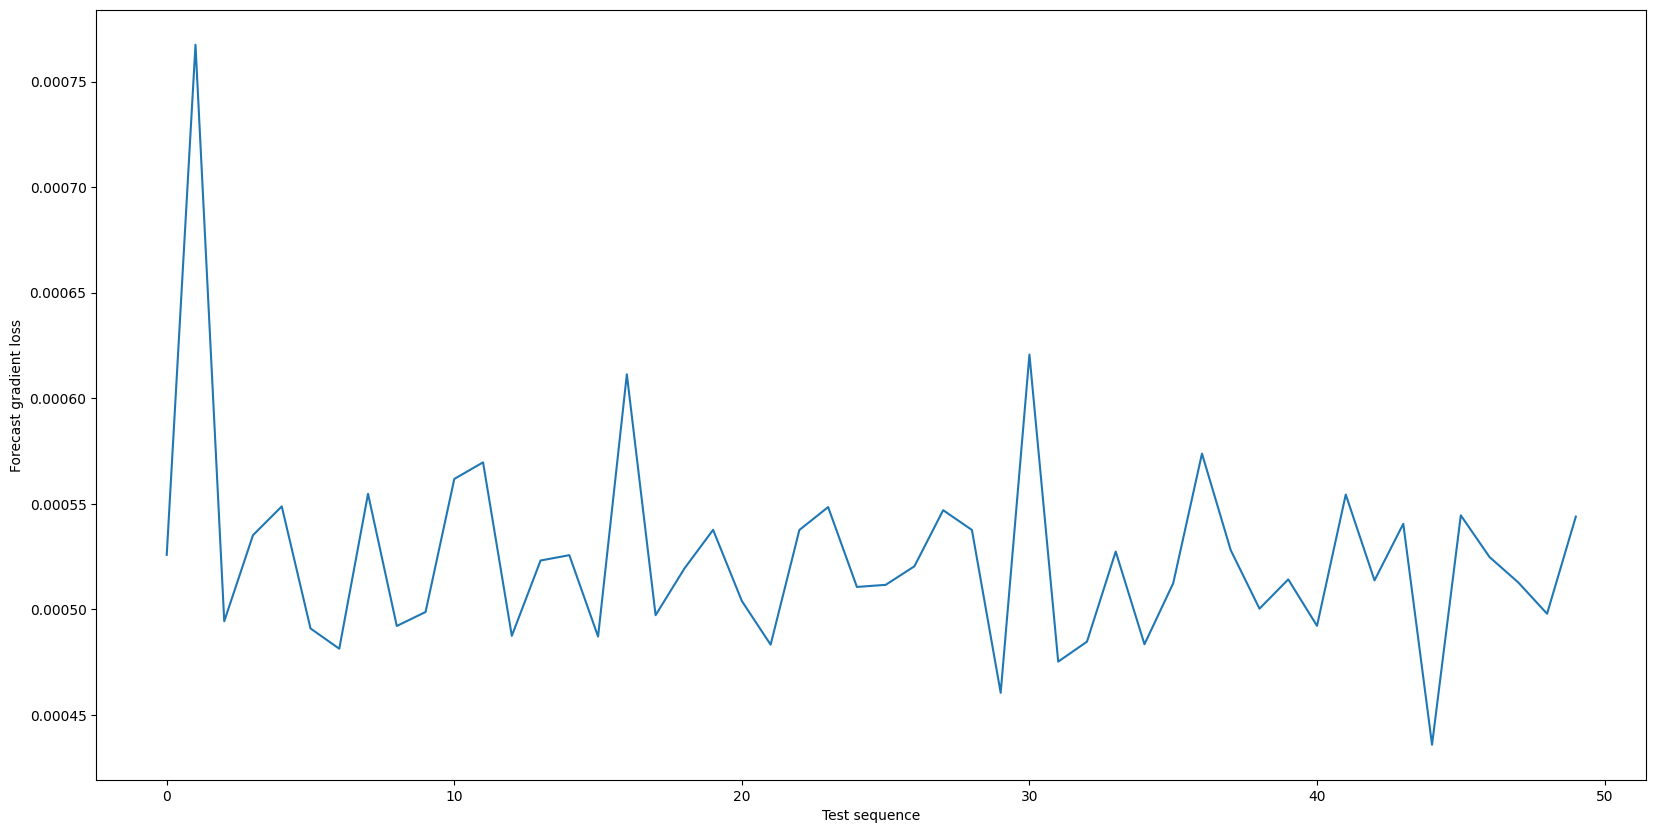

In [41]:
plt.figure(figsize=(20,10))
plt.plot(range(len(loss_log)), loss_log["Loss"], label='x{}'.format(i))
plt.ylabel("Forecast gradient loss")
plt.xlabel("Test sequence")
plt.show()

In [45]:
ksi = ksi_log[-1]
ksi_pd = pd.DataFrame(data=ksi, columns=(feature_name[1:dim + 1]), index=feature_name)
print('系数矩阵元素个数:', ksi.size)
print('非邻接特征数在总特征数中占比:{:.3f}%'.format(100 - np.count_nonzero(mask) / ksi.size * 100))
print('零元素占比:{:.3f}%'.format(100 - np.count_nonzero(ksi) / ksi.size * 100))
for i in range(dim):
    print("(x{})'=".format(i), end='')
    if_first = True
    for j in range(feature_num):
        if ksi[j, i] != 0:
            if findVariable(feature_name[j]):  # 一个用于检查公式中有无违背邻接关系的循环(非必要,可忽略)
                for v in findVariable(feature_name[j]):
                    if v not in GetAdjTable(dim)[i]:
                        print("wrong in the coefficient of {} in (x{})' 's formula".format(feature_name[j], i))
            if if_first:
                if_first = False
                print("{:.5f}*{}".format(ksi[j, i], ksi_pd.index[j].replace(' ', '')), end='')
            elif ksi[j, i] > 0:
                print(" +{:.5f}*{}".format(ksi[j, i], ksi_pd.index[j].replace(' ', '')), end='')
            else:
                print(" {:.5f}*{}".format(ksi[j, i], ksi_pd.index[j].replace(' ', '')), end='')
    print("\n")

系数矩阵元素个数: 504
非邻接特征数在总特征数中占比:63.095%
零元素占比:74.405%
(x0)'=-0.07961*1 -0.28849*x0x1 -0.18990*x0x2 +0.17775*x1^2 +0.16049*x2^2 +0.09105*x0^3 +0.21049*x0^2x1 +0.24260*x0^2x2 -0.26409*x0x1^2 -0.17796*x0x1x2 -0.36564*x0x2^2 -0.34642*x1^2x2 -0.11478*x1x2^2 +0.28741*x2^3

(x1)'=2.40786*1 -0.32264*x0 -0.06187*x1 +0.05912*x2 +0.05720*x0^2 -0.39210*x0x1 -0.13523*x0x2 -0.17323*x1^2 -0.09950*x2^2 -0.31508*x0^3 +0.09521*x0^2x1 +0.20428*x0^2x2 -0.10452*x0x2^2 -0.23367*x1^3 -0.19476*x1^2x2 -0.41747*x1x2^2 -0.13898*x2^3

(x2)'=2.98549*1 -0.07112*x0 -0.10287*x1 -0.05221*x3 +0.01011*x0^2 -0.05150*x0x3 -0.09963*x0x4 -0.14998*x1^2 -0.09615*x1x2 -0.12402*x1x4 -0.06338*x2x4 -0.02802*x3x4 -0.13515*x0^3 -0.17701*x0^2x1 +0.07092*x0^2x2 +0.13345*x0x1^2 +0.11269*x0x1x2 -0.17462*x0x1x3 +0.09670*x0x1x4 +0.04103*x0x2x4 -0.17179*x0x4^2 -0.09705*x1^3 -0.19886*x1^2x2 -0.06420*x1^2x3 -0.12064*x1^2x4 +0.02349*x1x2^2 +0.07468*x1x2x3 -0.26365*x1x2x4 -0.14950*x1x4^2 -0.03435*x2^2x3 +0.03230*x2x3x4 -0.18353*x2x4^2 -0.16489*x

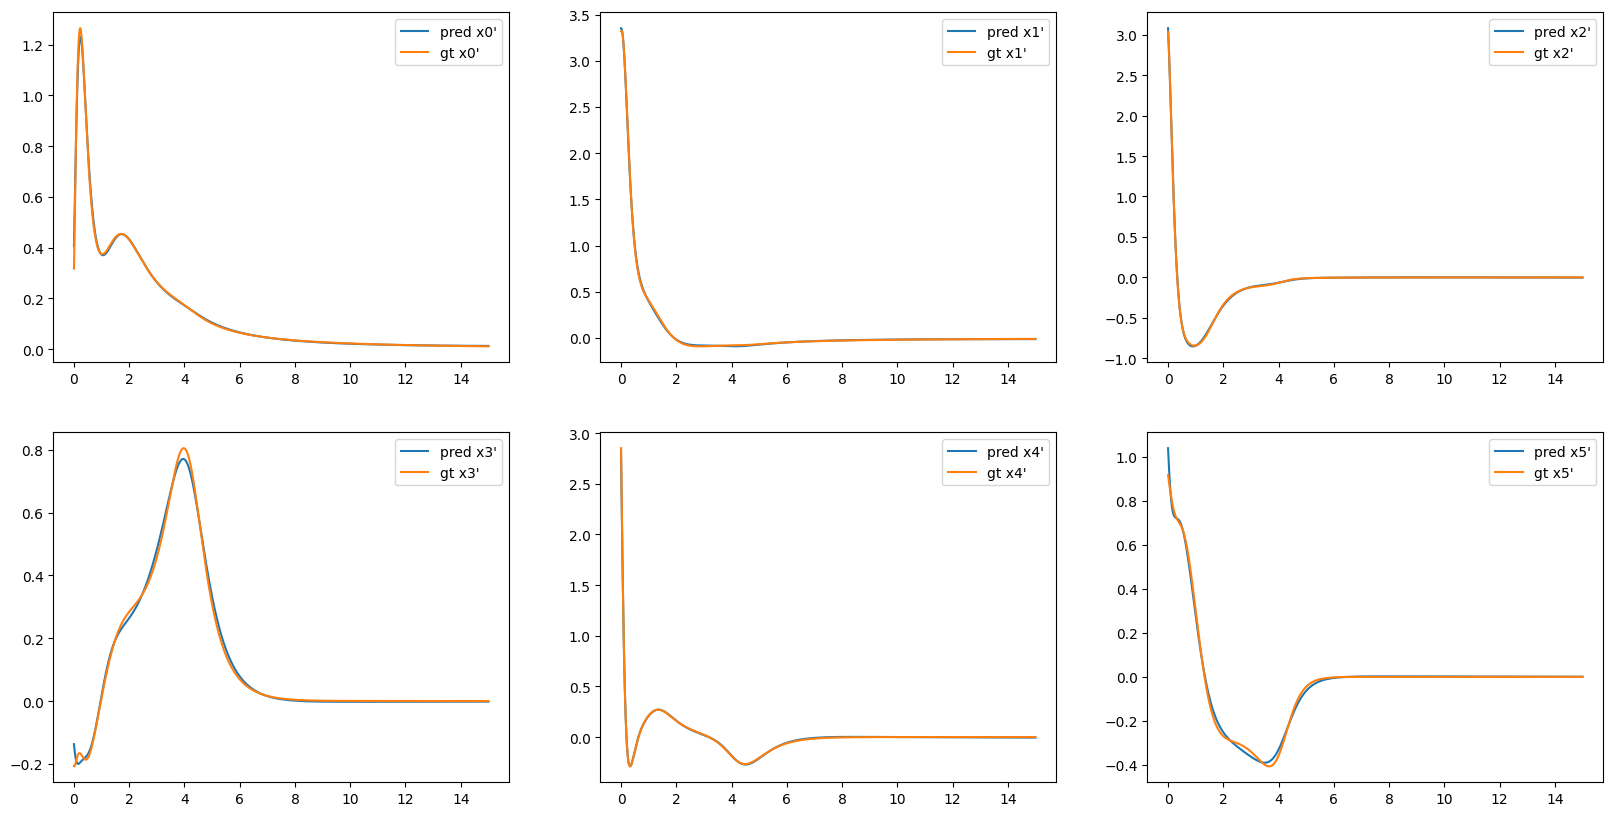

In [43]:
output = Theta @ ksi_log[-1]
plt.figure(figsize=(20, 10))
for i in range(dim):
    plt.subplot(231 + i)
    plt.plot(t, output[:, i], label="pred x{}'".format(i))
    plt.plot(t, dX[:, i], label="gt x{}'".format(i))
    plt.legend()

### 利用4th Order Runge Kutta Method预测序列

loss: 3.791314104262478e-05


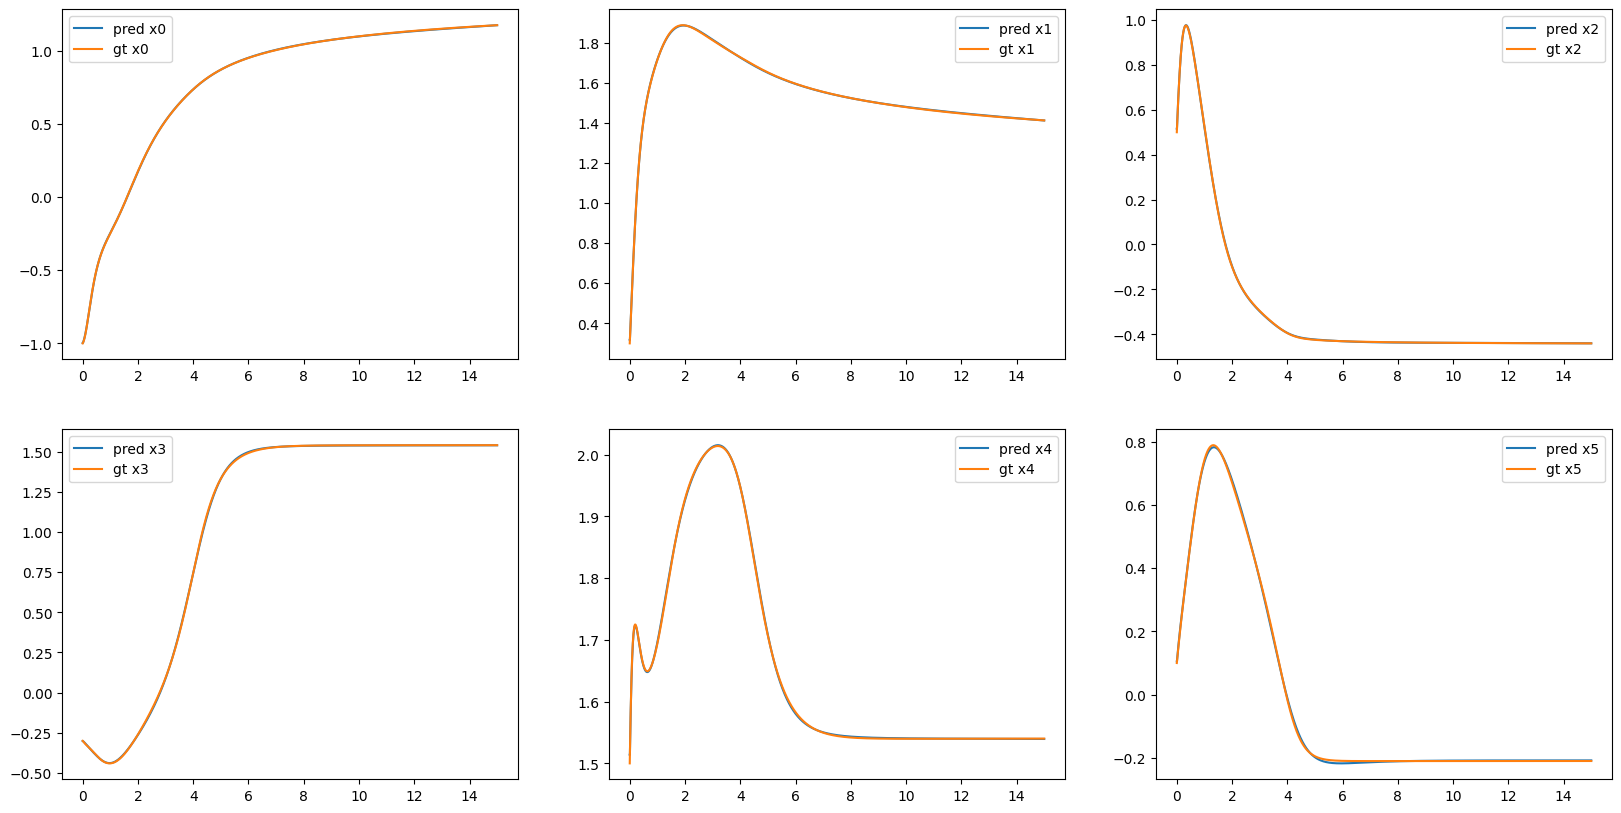

In [44]:
def RK4(x0, ksi, dt, time):

    def grad(x, ksi):
        library = PolynomialFeatures(degree=degree, include_bias=True)
        Theta = library.fit_transform(x)
        return Theta @ ksi

    x = x0.reshape(1, -1)
    pred = x
    for t in range(time):
        output1 = dt * grad(x, ksi)
        output2 = dt * grad(x + 0.5 * output1, ksi)
        output3 = dt * grad(x + 0.5 * output2, ksi)
        output4 = dt * grad(x + output3, ksi)
        x += (1 / 6) * (output1 + 2 * output2 + 2 * output3 + output4)
        pred = np.concatenate((pred, x), axis=0)
    return pred


x0 = np.copy(X[0, :])
pred = RK4(x0, ksi, dt, 3000)
loss = np.linalg.norm((X - pred))**2 / time
print("loss:", loss)
plt.figure(figsize=(20, 10))
for i in range(dim):
    plt.subplot(231 + i)
    plt.plot(t, pred[:, i], label='pred x{}'.format(i))
    plt.plot(t, X[:, i], label='gt x{}'.format(i))
    plt.legend()